# Copula Strategy Using Mispricing Index
This notebook demonstrates the usage of the `copula_strategy_mpi` module.
The framework of which was originally proposed in

* Xie, W., Liew, R.Q., Wu, Y. and Zou, X., 2016. Pairs trading with copulas. 

For a fundamental introduction of concepts in copula, please refer to the documentation for this module, or the basic copula strategy notebook.
The rest of the notebook is written assuming the reader in possession of basic understanding of those concepts.

## Introduction to the Strategy Framework
For convenience, the **mispricing index** implemented in the strategy will be referred as **MPI** when no ambiguity arises.

### A Quick Review of the Basic Copula Strategy
Before we introduce the MPI strategy, let's recall the basic copula strategy and understand its pros and cons.

The basic copula strategy proposed by [Liew et al. 2013] works with price series (or log-price series, which has identical suggested trading signals under the copula framework) and looks at conditional probabilities.
For example, if $P(X \le x_t | Y = y_t)$ is small for stock pair $(X, Y)$ with prices $(x_t, y_t)$, then stock $X$ is considered undervalued given the current price of $Y$.
Then we derive long/short positions regarding the spread based on this conditional probability.
This conditional probability is calculated from some copula fitted to the training data, and generally other models cannot produce this value.

Although this approach is in general reasonably sound, it has one critical drawback, that **the price series is not in general stationary**.
For example, if one adopt the assumption that stocks move in a lognormal (One may also argue that such assumption can be quite situational. We won't get into the details here.) fashion, then almost surely the price will reach any given level with enough time.

This implies that, if the basic copula framework was working on two stocks that has an upward(or downward) drift in the trading period, it may go out of range of the training period, and the conditional probabilities calculated from which will always be extreme values as $0$ and $1$, bringing in nonsense trading signals.
One possible way to overcome this inconvenience is to keep the training set up to date so it is less likely to have new prices out of range.
Another way is to work with a more likely stationary time series, for example, returns.

### How is the MPI Strategy Constructed?
At first glance, the MPI strategy documented in [Xie et al. 2016] looks quite bizarre.
However it is reasonably consistant when one goes through the logic of its construction:
In order to use returns to generate trading signals, one needs to be creative about utilizing the information.
It is one thing to know the dependence structure of a pair of stocks, it is another thing to trade based on it because intrinsically stocks are traded on prices, not returns.

If one regard using conditional probabilities as a distance measure, then it is natural to think about how far the returns have cumulatively driven the prices apart (or together), thereby introducing trading opportunities.

Hence we introduce the following concepts for the strategy framework:

#### Mispricing Index
**MPI** is defined as the conditional probability of returns, i.e., 
$$
MI_t^{X\mid Y} = P(R_t^X < r_t^X \mid R_t^Y = r_t^Y)
$$
$$
MI_t^{Y\mid X} = P(R_t^Y < r_t^Y \mid R_t^X = r_t^X)
$$
for stocks $(X, Y)$ with returns random variable at day $t$: $(R_t^X, R_t^Y)$ and returns value at day $t$: $(r_t^X, r_t^Y)$.
Those two values determines how mispriced each stock is, based on that day's return.
Note that so far only one day's return information contributes, and we want to add it up to cumulatively use returns to gauge how mispriced the stocks are.
Therefore we introduce the **flag** series:

#### Flag and Raw Flag
A more descriptive name than flag in my opinion would be **cumulative mispricing index**.
The **raw flag** series (with a star) is the cumulative sum of daily MPIs minus 0.5, i.e.,
$$
FlagX^*(t) = FlagX^*(t-1) + (MI_t^{X\mid Y} - 0.5), \quad FlagX^*(0) = 0.
$$
$$
FlagY^*(t) = FlagY^*(t-1) + (MI_t^{Y\mid X} - 0.5), \quad FlagY^*(0) = 0.
$$
Or equivalently
$$
FlagX^*(t) = \sum_{s=0}^t (MI_s^{X\mid Y} - 0.5)
$$
$$
FlagY^*(t) = \sum_{s=0}^t (MI_s^{Y\mid X} - 0.5)
$$
If one plots the raw flags series, they look quite similar to cumulative returns from their price series, which is what they were designed to do:
Accumulate information from daily returns to reflect information on prices.
Therefore, you may consider it as a fancy way to represent the returns series.

However, the **real flag** series (without a star, $FlagX(t), FlagY(t)$) **will be reset to $0$** whenever there is an exiting signal, which brings us to the trading logic.

### Trading Logic

The authors proposes a **dollar-neutral** trade scheme worded as follows:

Suppose stock $X$, $Y$ are associated with $FlagX$, $FlagY$ respectively.

Opening rules: ($D = 0.6$ in the paper)
* When $FlagX$ reaches $D$, we short-sell stock $X$ and buy stock $Y$ in **equal amounts**. ($-1$ Position)
* When $FlagX$ reaches $-D$, we short-sell stock $Y$ and buy stock $X$ in **equal amounts**. ($1$ Position)
* When $FlagY$ reaches $D$, we short-sell stock $Y$ and buy stock $X$ in **equal amounts**. ($1$ Position)
* When $FlagY$ reaches $-D$, we short-sell stock $X$ and buy stock $Y$ in **equal amounts**. ($-1$ Position)

Exiting rules: ($S = 2$ in the paper)
* If trades are opened based on $FlagX$, then they are closed if $FlagX$ returns to zero or reaches stop-loss position $S$ or $-S$.

* If trades are opened based on $FlagY$, then they are closed if $FlagY$ returns to zero or reaches stop-loss position $S$ or $-S$.

* After trades are closed, both $FlagX$ and $FlagY$ are reset to $0$.

The rationale behind the dollar-neutral choice might be that (the authors did not mention this), because the signals are generated by returns, it makes sense to "reset" returns when entering into a long/short position.

#### Ambiguities
The authors did not specify what will happen if the following occurs:

1. When $FlagX$ reaches $D$ (or $-D$) and $FlagY$ reaches $D$ (or $-D$) together.
2. When in a long(or short) position, receives a short(or long) trigger.
3. When receiving a opening and exiting signal together.
4. When the position was open based on $FlagX$ (or $FlagY$), $FlagY$ (or $FlagX$) reaches $S$ or $-S$.

Here is our take on the above issues:

1. Do nothing.
2. Change to the trigger position. For example, long position with a short trigger will go short.
3. Go for the exiting signal.
4. Do nothing.

## `CopulaStrategyMPI` Functionality ##
Tools included in the module enables the users to conduct the following workflow:

* Initiate the `CopulaStrategyMPI` class with options to set custom $D$ value `opening_triggers` and $S$ value `stop_loss_positions`, and the option to side-load a fitted `Copula` object.
* Calculate returns from price series using `to_returns` method.
* Calculate daily MPIs from returns using `calc_mpi` method.
  This step is optional and you do not need the MPI series to do other things.
  Other methods that uses MPIs will calculate them internally.
* Fit returns to different kinds of copulas using `fit_copula` method.
* Sample plotting from the copula in the `copula` class attribute, using `graph_copula` method.
* Get positions and flags from testing/trading data, using `get_positions_and_flags` method.
* Translate positions to the number of units to hold for a dollar-neutral approach, using `positions_to_units_dollar_neutral` method.

A few notes:

1. This module is pandas based, instead of numpy based as in the basic `CopulaStrategy` module.
   In the near future the basic module will also support pandas.
2. The output is *very sensitive* to the values of `opening_triggers` and `stop_loss_positions`, to the point that it may determine whether this strategy profits or loses.
3. If you just want to have the raw flag series, simply toggle `enable_reset_flag` to `False`. But this logically conflicts with the exiting logic generation so do not use the trading signal under this condition.
4. If you want to have the raw flag series AND trade on it, you need to set `stop_loss_positions` to `(-np.inf, np.inf)` and toggle `enable_reset_flag` to `False`. Although based on our tests, this strategy is not likely to profit.

## Usage ##
The demonstratration part has the following sections using real world data:
1. Importing and Data Pre-processing.
2. Fitting Data to Different Copulas with Training Data.
3. Generating Trading Positions using Testing Data.
4. Possible Issues Discussion.

### 1. Importing and Data Preprocessing

I have also included the 2009-2011 data for BKD and ESC. Simply uncomment accordingly for cell 2, 3 and 4.

In [1]:
# Importing libraries and modules
import pandas as pd
import numpy as np
import datetime as dt  # For plotting x-axis as dates
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arbitragelab.copula_approach.copula_strategy_mpi import CopulaStrategyMPI
import arbitragelab.copula_approach.copula_calculation as ccalc

In [19]:
# Importing data
# I also included the 2009-2011 data. Uncomment to use.
# pair_prices = pd.read_csv(r'BKD_ESC_2009_2011.csv', index_col=0)
pair_prices = pd.read_csv(r'BKD_ESC_2008_2009_June.csv', index_col=0)
# Formatting dates
formatted_dates = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in pair_prices.index]
pair_prices.index = formatted_dates

BKD_series = pair_prices['BKD']
ESC_series = pair_prices['ESC']

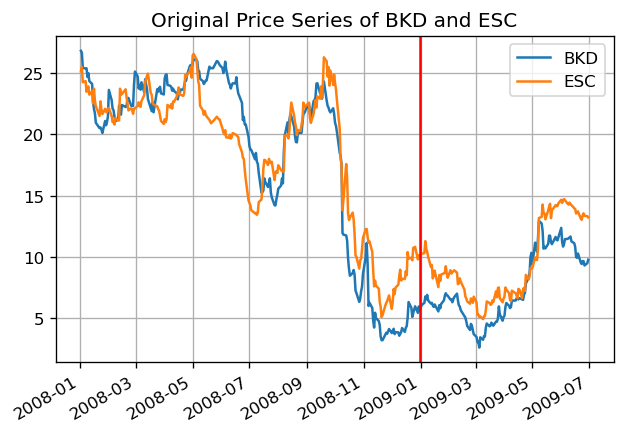

In [16]:
plt.figure(dpi=120)
plt.plot(formatted_dates, BKD_series, label='BKD')
plt.plot(formatted_dates, ESC_series, label='ESC')
# plt.axvline(dt.date(2012, 1, 3), color='red')  # Training testing split date
plt.axvline(dt.date(2008, 12, 31), color='red')  # Training testing split date
plt.legend()
plt.grid()
plt.gcf().autofmt_xdate()
plt.title(r'Original Price Series of BKD and ESC')
plt.show()

In [4]:
# Initiate the analysis module
CSMPI = CopulaStrategyMPI()

# Training and testing split. Note that this module works with returns series.
# training_length = 756# From 01/02/2008 to 12/30/2008 (m/d/y)
training_length = 252# From 01/02/2008 to 12/30/2008 (m/d/y)

BKD_train = CSMPI.to_returns(BKD_series[ : training_length])
ESC_train = CSMPI.to_returns(ESC_series[ : training_length])
BKD_train_prices = BKD_series[ : training_length]
ESC_train_prices = ESC_series[ : training_length]
# train_dates = formatted_dates[ : training_length]

BKD_test = CSMPI.to_returns(BKD_series[training_length : ])
ESC_test = CSMPI.to_returns(ESC_series[training_length : ])
BKD_test_prices = BKD_series[training_length : ]
ESC_test_prices = ESC_series[training_length : ]
# test_dates = formatted_dates[training_length : ]

# Empirical CDF for the training set.
cdf1 = ccalc.find_marginal_cdf(BKD_train)
cdf2 = ccalc.find_marginal_cdf(ESC_train)

cdf1_price = ccalc.find_marginal_cdf(BKD_train_prices)
cdf2_price = ccalc.find_marginal_cdf(ESC_train_prices)

Let's at first scatter plot the training data to have a grasp on its dependence structure, and determine which copula it should fit.

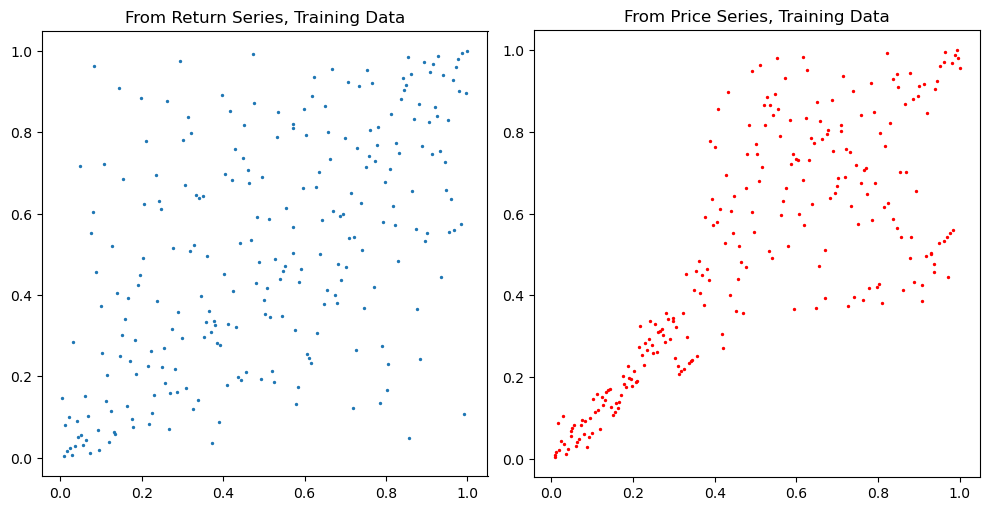

In [5]:
# Scatter plot the training data.
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi=100)
axs[0].scatter(cdf1(BKD_train), cdf2(ESC_train), s=2)
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_title(r'From Return Series, Training Data')

axs[1].scatter(cdf1_price(BKD_train_prices), cdf2_price(ESC_train_prices), s=2, color='r')
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_title(r'From Price Series, Training Data')
plt.tight_layout()
plt.show()

**Note: We only use the returns series for the MPI strategy. The price series scatter plot is just for visual comparison.**

The returns plot exhibits some tail dependencies on the lower-left corner.
There might also be some tail dependencies on the upper-right corner, but it is not directly obvious.
When compared to the price series scatter plot, the price series shows much stronger lower dependency and no clear upper dependency.
In terms of market movement, the two plots indicate that both returns and prices tend to move downward together, but not upward together, at least the interdependence is not as strong as downward movements.
Considering the training data is in year 2008, those scatter plots make sense.

### 2. Fitting Data to Different Copulas with Training Data

Regarding which copulas best describe the structure, we propose using N14 and Student-t for their strong lower dependencies, and similarities on the upper right corner.
One may fit to as much the copulas as they wish in the `copula_approach` package.

In [6]:
# Fit to N13, Clayton and Student-t , Gumbel, Frank, N14 copulas respectively, and print the scores.
result_dict_n13,     copula_n13, _, _     = CSMPI.fit_copula(BKD_train, ESC_train, copula_name='N13')
result_dict_clayton, copula_clayton, _, _ = CSMPI.fit_copula(BKD_train, ESC_train, copula_name='Clayton')
result_dict_t,       copula_t, _, _       = CSMPI.fit_copula(BKD_train, ESC_train, copula_name='Student')
result_dict_gumbel,  copula_gumbel, _, _  = CSMPI.fit_copula(BKD_train, ESC_train, copula_name='Gumbel')
result_dict_frank,   copula_frank, _, _   = CSMPI.fit_copula(BKD_train, ESC_train, copula_name='Frank')
result_dict_n14,     copula_n14, _, _     = CSMPI.fit_copula(BKD_train, ESC_train, copula_name='N14')

# Print fit scores
print(result_dict_n13)
print(result_dict_clayton)
print(result_dict_t)
print(result_dict_gumbel)
print(result_dict_frank)
print(result_dict_n14)

{'Copula Name': 'N13', 'SIC': -105.94681640898858, 'AIC': -109.4602454965, 'HQIC': -108.05607635438662}
{'Copula Name': 'Clayton', 'SIC': -101.88027859448783, 'AIC': -105.39370768199925, 'HQIC': -103.98953853988587}
{'Copula Name': 'Student', 'SIC': -121.7779694993804, 'AIC': -125.29139858689182, 'HQIC': -123.88722944477844}
{'Copula Name': 'Gumbel', 'SIC': -105.26036256358641, 'AIC': -108.77379165109782, 'HQIC': -107.36962250898445}
{'Copula Name': 'Frank', 'SIC': -90.70833326562915, 'AIC': -94.22176235314056, 'HQIC': -92.81759321102719}
{'Copula Name': 'N14', 'SIC': -128.5867816510987, 'AIC': -132.10021073861014, 'HQIC': -130.69604159649674}


Note that we are working with the returns series, which in general is much noisier than price series, and has a lower level of correlation.

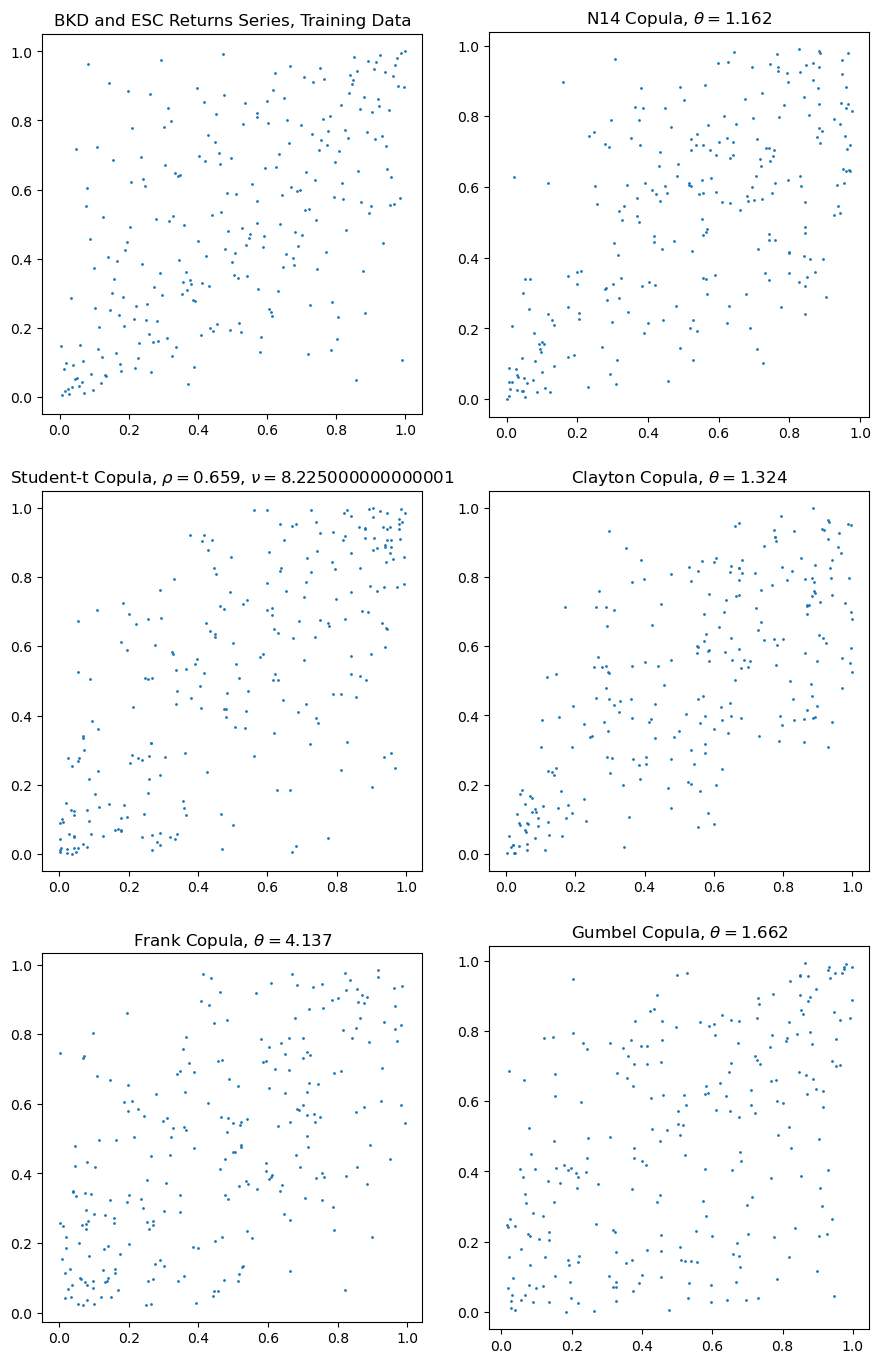

In [7]:
# Scatter plot the training data vs the fitted copulas
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9,14), dpi=100)
# axs[0, 0]: Empirical.
axs[0, 0].scatter(cdf1(BKD_train), cdf2(ESC_train), s=1)
axs[0, 0].set_aspect('equal', adjustable='box')
axs[0, 0].set_title(r'BKD and ESC Returns Series, Training Data')
axs[0, 0].set_xlim([-0.05, 1.05])
axs[0, 0].set_ylim([-0.05, 1.05])
plt.tight_layout()

# axs[0, 1]: N14.
CSMPI.graph_copula(copula_name='N14', theta=copula_n14.theta,
                   ax=axs[0, 1], s=1, num=len(ESC_train))

# axs[1, 0]: Student-t.
CSMPI.graph_copula(copula_name='Student', cov=copula_t.cov, nu=copula_t.nu,
                   ax=axs[1, 0], s=1, num=len(ESC_train))
# axs[1, 1]: Clayton.
CSMPI.graph_copula(copula_name='Clayton', theta=copula_clayton.theta,
                   ax=axs[1, 1], s=1, num=len(ESC_train))
# axs[2, 0]: Frank.
CSMPI.graph_copula(copula_name='Frank', theta=copula_frank.theta,
                   ax=axs[2, 0], s=1, num=len(ESC_train))
# axs[2, 1]: Gumbel.
CSMPI.graph_copula(copula_name='Gumbel', theta=copula_gumbel.theta,
                   ax=axs[2, 1], s=1, num=len(ESC_train))
plt.show()

Now we choose Student-t and N14 copula to generate trading signals.

### 3. Generating Trading Positions using Testing Data

We are using a dollar neutral strategy, and the buy/sell/hold is based on "flag" series, calculated from accumulations of mispricing indices.
For more detail, please refer to the beginning of the notebook.

In [8]:
# Make two strategy classes with the fitted Student and N14 copula.
CSMPI_t = CopulaStrategyMPI(copula=copula_t, opening_triggers=(-0.6, 0.6), stop_loss_positions=(-2, 2))
CSMPI_n14 = CopulaStrategyMPI(copula=copula_n14, opening_triggers=(-0.6, 0.6), stop_loss_positions=(-2, 2))

# Get positions and flag series
returns_test = pd.concat([BKD_test, ESC_test], axis=1)
positions_t, flags_t     = CSMPI_t.get_positions_and_flags(returns=returns_test, cdf1=cdf1, cdf2=cdf2,
                                                           enable_reset_flag=True)
positions_n14, flags_n14 = CSMPI_n14.get_positions_and_flags(returns=returns_test, cdf1=cdf1, cdf2=cdf2,
                                                             enable_reset_flag=True)
# Shift the positions by 1 day
positions_t = positions_t.shift(1)
positions_n14 = positions_n14.shift(1)
positions_t[0] = 0
positions_n14[0] = 0

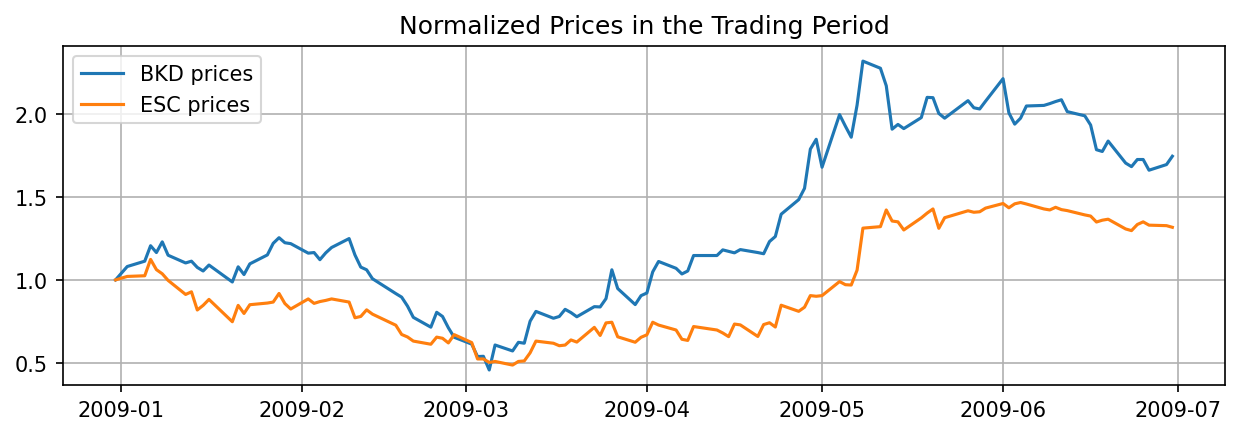

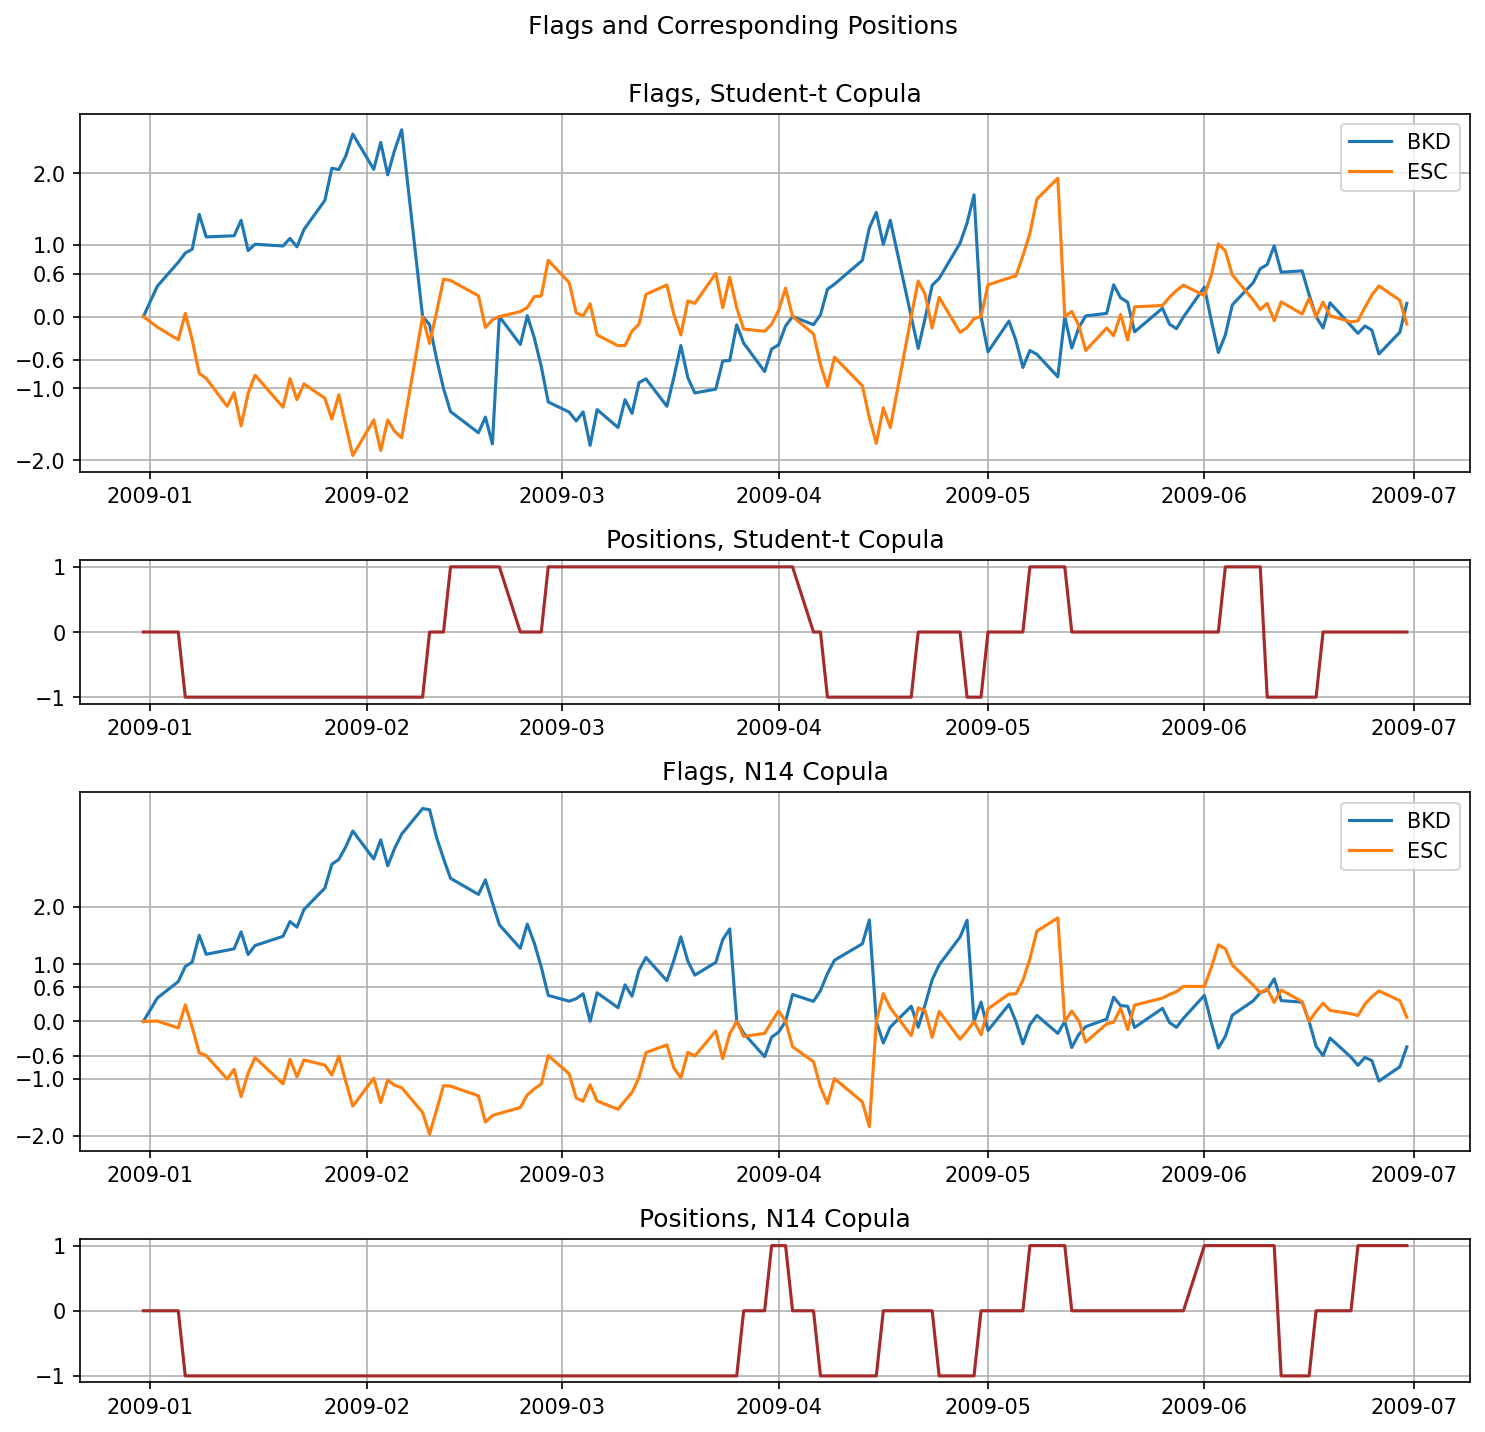

In [9]:
# As a referece we also plot the normalized price series from the two stocks.
plt.figure(figsize=(10, 3), dpi=150)
plt.plot(BKD_test_prices / BKD_test_prices[0], label='BKD prices')
plt.plot(ESC_test_prices / ESC_test_prices[0], label='ESC prices')
plt.title('Normalized Prices in the Trading Period')
plt.legend()
plt.grid()
plt.show()

# Plot positions and flags
fig, axs = plt.subplots(4, 1, gridspec_kw={'height_ratios': [1, 0.4, 1, 0.4]}, figsize=(10,10), dpi=150)
fig.suptitle('Flags and Corresponding Positions')
# Plotting flags for Student-t copula
axs[0].plot(flags_t['BKD'], label='BKD')
axs[0].plot(flags_t['ESC'], label='ESC')
axs[0].title.set_text('Flags, Student-t Copula')
axs[0].legend()
axs[0].grid()
axs[0].set_yticks([-2, -1, -0.6, 0, 0.6, 1, 2])
# Plotting positions for Student-t copula
axs[1].plot(positions_t, label='Positions', color='brown')
axs[1].title.set_text('Positions, Student-t Copula')
axs[1].grid()
axs[1].set_yticks([-1,0,1])
# Plotting flags for N14 copula
axs[2].plot(flags_n14['BKD'], label='BKD')
axs[2].plot(flags_n14['ESC'], label='ESC')
axs[2].title.set_text('Flags, N14 Copula')
axs[2].legend()
axs[2].grid()
axs[2].set_yticks([-2, -1, -0.6, 0, 0.6, 1, 2])
# Plotting positions for N14 copula
axs[3].plot(positions_n14, label='Positions', color='brown')
axs[3].title.set_text('Positions, N14 Copula')
axs[3].grid()
axs[3].set_yticks([-1,0,1])

fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Avoid title overlap
plt.show()

## Forming Equity Curves
The authors proposes a dollar-neutral trading strategy and therefore, we can represent the P&L of the strategy in returns.

**Note:**

The authors claimed a relatively robust 8-10% returns from this strategy in the formation period.
We are pretty positive that the rules proposed in the paper were implemented correctly in the `CopulaStrategyMPI` module with thorough unit testing on every possible case.
However we cannot get the claimed returns.

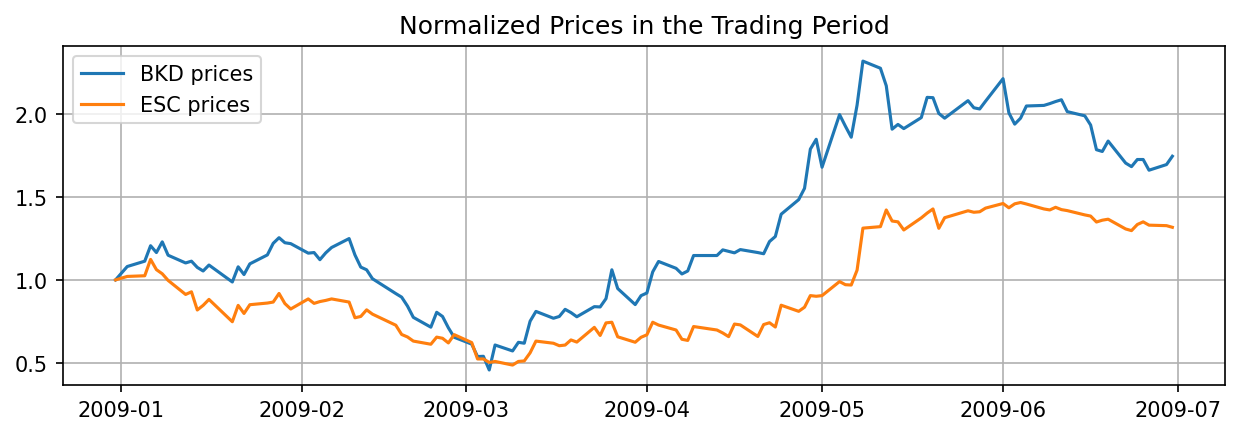

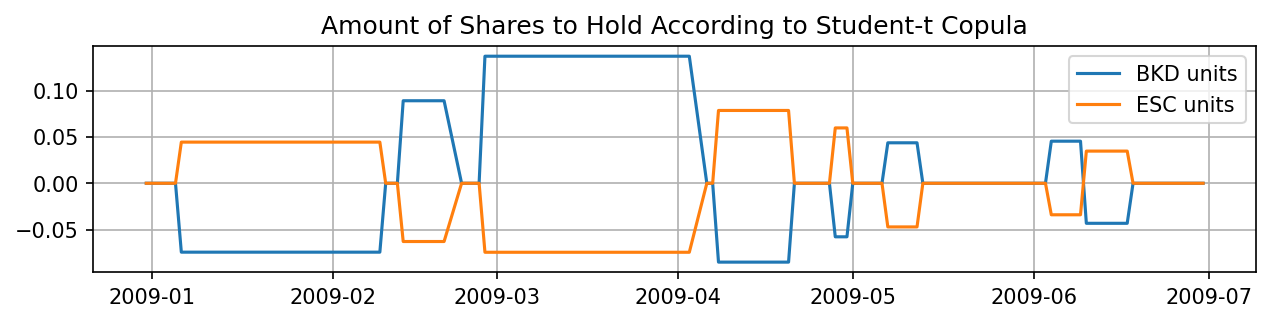

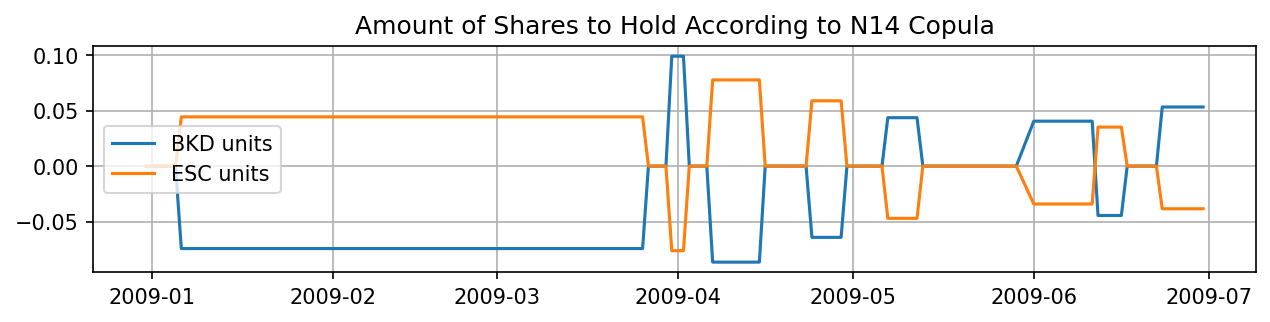

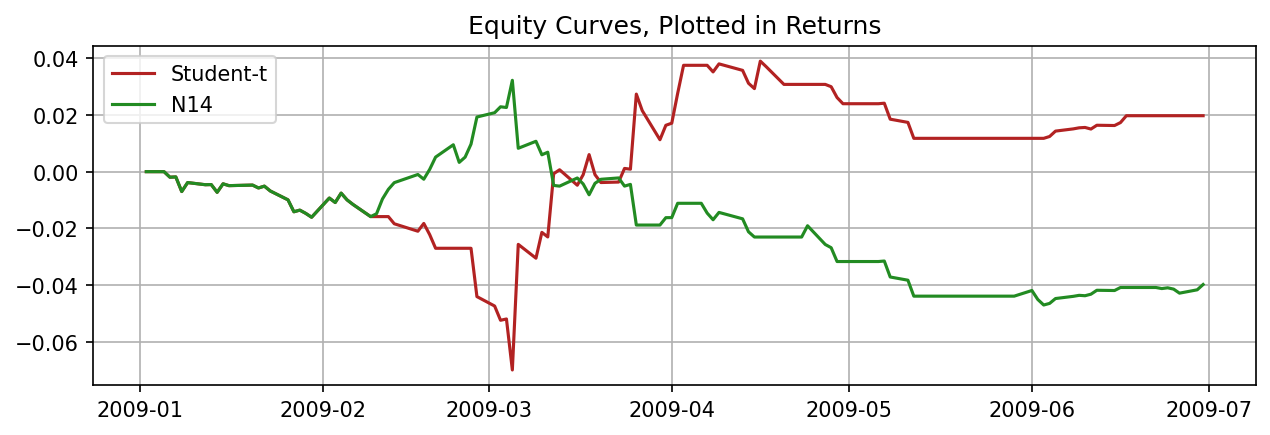

In [17]:
# As a referece we also plot the normalized price series from the two stocks.
plt.figure(figsize=(10, 3), dpi=150)
plt.plot(BKD_test_prices / BKD_test_prices[0], label='BKD prices')
plt.plot(ESC_test_prices / ESC_test_prices[0], label='ESC prices')
plt.title('Normalized Prices in the Trading Period')
plt.legend()
plt.grid()
plt.show()

# Calculate returns from the strategy, i.e., assuming 1$ initial investment and calculate P&L.
# 1. Calculate the unit holding series
test_prices = pd.concat([BKD_test_prices, ESC_test_prices], axis=1)
units_df_t = CSMPI.positions_to_units_dollar_neutral(prices_df=test_prices, positions=positions_t)
units_df_n14 = CSMPI.positions_to_units_dollar_neutral(prices_df=test_prices, positions=positions_n14)
# 2. Plot the units series
plt.figure(figsize=(10, 2), dpi=150)
plt.plot(units_df_t['BKD'], label='BKD units')
plt.plot(units_df_t['ESC'], label='ESC units')
plt.title('Amount of Shares to Hold According to Student-t Copula')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 2), dpi=150)
plt.plot(units_df_n14['BKD'], label='BKD units')
plt.plot(units_df_n14['ESC'], label='ESC units')
plt.title('Amount of Shares to Hold According to N14 Copula')
plt.legend()
plt.grid()
plt.show()

# 3. Calculate Daily P&L of the strategy based on the units holding for each security
portfolio_pnl_t = BKD_test * units_df_t['BKD'] + ESC_test * units_df_t['ESC']
portfolio_pnl_n14 = BKD_test * units_df_n14['BKD'] + ESC_test * units_df_n14['ESC']

# 4. Calculate and plot the equity curve
equity_t = portfolio_pnl_t.cumsum()
equity_n14 = portfolio_pnl_n14.cumsum()

plt.figure(figsize=(10, 3), dpi=150)
plt.plot(equity_t, label='Student-t', color='firebrick')
plt.plot(equity_n14, label='N14', color='forestgreen')
plt.title('Equity Curves, Plotted in Returns')
plt.legend()
plt.grid()
plt.show()

### 4. Possible Issues DIscussion
1. The strategy's outcome is quite sensitive to the values of opening and exiting triggers to the point that a well-fitted copula with a not good sets of parameters can actually lose money.

2. The trading signal is generated from the flags series, and the flags series will be calculated from the copula that we use to model.
   Therefore the explanability suffers.
   Also it is based on the model in second order, and therefore the flag series and the suggested positions will be quite different across different copulas, making it not stable and not directly comparable mutually.

3. The way the flags series are defined does not handle well when both stocks are underpriced/overpriced concurrently.

4. Because of flags will be reset to 0 once there is an exiting signal, it implicitly models the returns as martingales that do not depend on the current price level of the stock itself and the other stock.
   Such an assumption may be situational, and the user should be aware. (White noise returns do not imply that the prices are well cointegrated.)
   
5. The strategy is betting the flags series having dominating mean-reversion behaviors, for a pair of cointegrated stocks.
   It is not mathematically clear what justifies the rationale.
   
6. If accumulating mispricing index is basically using returns to reflect prices, and the raw flags look basically the same as normalized prices, why not just directly use normalized prices?

## Conclusion

(This section follows from [Xie et al. 2016])

* Copulas are able to capture both linear and non-linear relations between random variables, it is possible that the proposed method captures strong non-linear associations that the traditional methods such as distance measure tend to neglect.

* Using returns overcomes the criticism that the prices series not being stationary, as used by [Liew et al. 2013].

## References ##
- [Xie, W., Liew, R.Q., Wu, Y. and Zou, X., 2016. Pairs trading with copulas. The Journal of Trading, 11(3), pp.41-52.](https://efmaefm.org/0efmameetings/EFMA%20ANNUAL%20MEETINGS/2014-Rome/papers/EFMA2014_0222_FullPaper.pdf)
- [Liew, R.Q. and Wu, Y., 2013. Pairs trading: A copula approach. Journal of Derivatives & Hedge Funds, 19(1), pp.12-30.](https://dr.ntu.edu.sg/bitstream/10220/17826/1/jdhf20131a.pdf)